PART 2

Hello,

Welcome to the hydraulic assesment tool. Step by step you will be guided to asses the maximum natural discharge of a river based on its hydraulic geometry. To start here you need to have:

- Installed SFINCS
- Installed hydromt-sfincs
- A DEM of your area
- Available data


First make sure everything is installed and ready for use

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

import hydromt
from hydromt_sfincs import SfincsModel
from hydromt.log import setuplog
from hydromt_sfincs import utils
import numpy as np
import pandas as pd
import geopandas as gpd

logger = setuplog("prepare data catalog", log_level=10)

2024-02-29 14:54:33,012 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


Here is where we add the DEM to SFINCS library and all the input is.

In [2]:
#Under here is the example. Everything is necessary
# The crs you can look up what is compatible for your area. The DEM you should store in the datafiles map

datayml = f"""
meta:
    name: Narok
narok1:
    path: datafiles/narok.DEM15Final.tif  
    data_type: RasterDataset
    driver: raster
    crs: 32736
    meta:
        category: topography
    nodata: 1850
"""
# meta:
#     name: 
# name2:
#     path:  
#     data_type: RasterDataset
#     driver: raster
#     crs: 
#     meta:
#         category: topography
#     nodata: 

#     """

data_lib = "Narok.yml"    #This is the name you use later
with open(data_lib, mode="w") as f:
    f.write(datayml)

In [3]:
data_catalog = hydromt.DataCatalog(data_libs=[data_lib], logger=logger)
data_catalog.from_yml(data_lib) 

2024-02-29 14:54:35,540 - prepare data catalog - data_catalog - INFO - Parsing data catalog from Narok.yml
2024-02-29 14:54:35,545 - prepare data catalog - data_catalog - INFO - Parsing data catalog from Narok.yml


,provider,version,path,data_type,driver,category
name,,,,,,
narok1,None,None,c:\Users\pjdeb\OneDrive\Documenten\Universitei...,RasterDataset,raster,topography


In [4]:
# root_folder  = Path('Results_hydromt')
root_folder  = Path('../TOOL/Results_hydromt')

# This is the root where hydromt saves all the files for SFINCS to use

In [5]:
#Configuration
# Here is where the DEM and SFINCS meet
# Please read SFINCS manual for more details. This is the least necessary you need

sf = SfincsModel(data_libs=["Narok.yml"], root=root_folder, mode="w+")

sf.setup_config(
    **{ "tref": "20230101 000000",  
        "tstart": "20230101 000000", 
        "tstop": "20230101 040000",
        
      "res": 10,                # model resolution in meters
      "crs": "utm",             # model CRS (must be UTM zone)

      "manning": 0.0516 ,       # Manning coefficient
      "manning_land": 0.0516,
      
      "dtout": 300,             # This is for every 300 secoond SFINCS makes a measurement
      "theta": 1,               # Should always be 1
      "alpha": 0.1,             # alpha can be between 0.1 and 1, if your SFINCS does not run smooth lower this
      "qinf": 2                 # Infiltration rate of the ground in mm/hr
    }
    )


Model dir already exists and files might be overwritten: c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\TOOL\Results_hydromt\gis.


In [6]:
# create grid
# You need the coordinates of your DEM, x0 and y0 are the coordinates of the bottom left corner
# More detailed explanation try SFINCS manual
inp_dict = {
    "x0": 818844.0420000000158325,  #These are the coordinates of the example DEM
    "y0": 9879027.8399000000208616,  
    "dx": 5,                        #These is in meters. Make it so your grid does not have more than 500 cells in a row for fast simulation
    "dy": 5,
    "nmax": 110,                    # These are the number of cells mentioned by dx
    "mmax": 210,                    
    "rotation": 0,
    "epsg": 32736,                  # Same as crs DEM
}

grid = sf.setup_grid(**inp_dict)

Again the Narok example below here. 
First is given the x, y coordinates of the waterdischarge points. From QGIS you can get the coordinates where you want to place them. 

Note that index is the indication of the number of points as well. 
Another important part is the periods, if you want you can make it as big or small as you want. 
This is part of the example, The only parts you need to change are marked with ### at the end of the line

In [7]:
#waterdischarge
# Here we specify at what x&y-locations we have measured/modelled input water level data in the bndfile of SFINCS:

# x&y-locations in same coordinate reference system as the grid:
# In this example there are 3 waterdischarge points, they are noted like this.
x = [818876.48, 819476.572, 819691.68]                                          ###
y = [9879309.01, 9879495.408, 9879424.72]                                       ###

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1, 2, 3]  # NOTE that the index should start at one                    ###
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

time = pd.date_range(
    start=utils.parse_datetime(sf.config["tstart"]),
    end=utils.parse_datetime(sf.config["tstop"]),
    periods=8,  # periods, because there are 4 hours each period is 30 minutes  ###
)

# DISCHARGE INPUT
dis = np.array([                                                                ###
    [30, 1, 1],    #0:00
    [30, 1, 1],
    [30, 1, 1],
    [30, 1, 1],
    [420, 1, 1], 
    [30, 1, 1],
    [30, 1, 1],
    [30, 1, 1]]                                                                  ###
)   

dispd = pd.DataFrame(index=time, columns=index, data=dis)

# show what has been created:
display(bnd)


# now we call the function setup_discharge_forcing, which adds the discharge forcing to the src points
sf.setup_discharge_forcing(timeseries=dispd,locations=bnd)

,geometry
1,POINT (818876.480 9879309.010)
2,POINT (819476.572 9879495.408)
3,POINT (819691.680 9879424.720)


In [9]:
# Observatory points and lines
# Instead of the coordinates put in hydromt, this is a vector layer made in QGIS, saved as a geosjon file and imported.
# The observatory points give you all the information of SFINCS on those locations. 
sf.setup_observation_points(
    locations=Path(r"datafiles\observatorypoints.geojson"), merge=True)


# NOTE: the observation points are now stored in the sf.geoms dictionary
sf.geoms.keys()

dict_keys(['obs'])

For every bit of code there is some adjustment.
Below here is the input of the DEM and make it compatible for SFINCS.
Important detail is alse the waterlevel boundary.
The waterlevel boundary is the part of the model where the water can exit the model. Else it will fill like a bathtub and crash. 
It is based of on elevation. So you need to know the elevation of your model. 

2024-02-29 14:54:55,488 - prepare data catalog - data_catalog - INFO - Parsing data catalog from narok.yml
2024-02-29 14:54:55,493 - prepare data catalog - rasterdataset - INFO - Reading narok1 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\TOOL\datafiles\narok.DEM15Final.tif


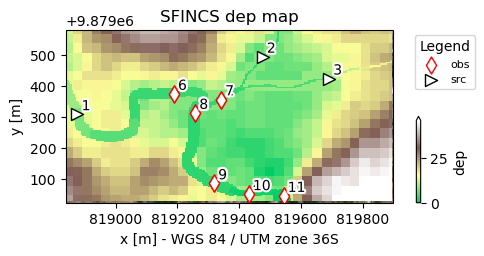

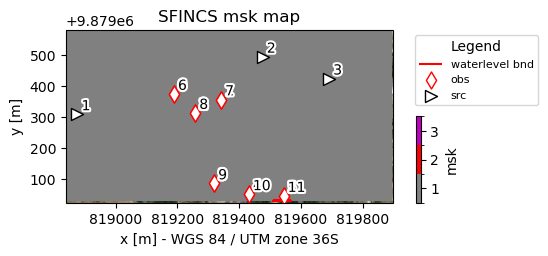

In [10]:
#elevation
data_catalog = hydromt.DataCatalog(data_libs=["narok.yml"], logger=logger)  #Use the same name as you saved the library of your DEMS
da = data_catalog.get_rasterdataset("narok1")                               # Here is the specific DEM you used out of you library 

da = da-1842                    #THIS IS SOMETHING I DID TO MAKE THE LOWEST POINT 0 in the NArok example. 

sf.setup_dep(datasets_dep=[{"da":da}])
sf.plot_basemap(variable="dep", 
                bmap="sat", 
                zoomlevel=15)


#mask
sf.setup_mask_active(zmin=0, reset_mask=True)

# The code here is for the water to exit the model. 
sf.setup_mask_bounds(btype="waterlevel",
                     zmax = 0.6,                #This is 0.6 because the lowest point is 0. Else it would be 1842.6
                     reset_bounds=True)

fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=15)

In [11]:
## SUBGRID
# Subgrid allows for the model to work with more details without using a lot of time.  
sf.setup_subgrid(
    datasets_dep= [{"da":da}],
    nr_subgrid_pixels = 10 ,    #Fill in number of subgrid files Make it so your grid is 1x1 meter at least. 
    write_dep_tif=True          # The 10 stands for hoe much you devide your grid cells of hydromt.
)                               # If you grid cells are 30x30, by putting 10 he makes them 3x3 meter.     

Below here is a check is everything worked. It should look some thing like this:

['gis', 'hydromt.log', 'sfincs.dep', 'sfincs.dis', 'sfincs.exe', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk', 'sfincs.obs', 'sfincs.sbg', 'sfincs.src', 'sfincs_his.nc', 'sfincs_log.txt', 'sfincs_map.nc', 'subgrid', 'zsmax.dat']

In [12]:
sf.write() # write all
dir_list = os.listdir(sf.root)
print(dir_list)

['gis', 'hdf5.dll', 'hdf5_hl.dll', 'hydromt.log', 'hydromt_data.yml', 'libifcoremd.dll', 'libiomp5md.dll', 'libmmd.dll', 'LICENSE.txt', 'LICENSING CONDITIONS for Free Trial Copy.txt', 'netcdf.dll', 'none', 'run.bat', 'sfincs.dep', 'sfincs.dis', 'sfincs.exe', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk', 'sfincs.obs', 'sfincs.sbg', 'sfincs.src', 'sfincs_his.nc', 'sfincs_log.txt', 'sfincs_map.nc', 'subgrid', 'svml_dispmd.dll', 'zlib1.dll', 'zsmax.dat']


In [13]:
fn = os.path.join(root_folder, "run.bat")

with open(fn, "r") as f:
    txt = f.read()
print(txt)

call "sfincs.exe">sfincs_log.txt 

pause


In [15]:
# Change these paths yourself!
# This is the path to where you stored SFINCS
source_folder = Path(r"C:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\SFINCS\SFINCS_v2.0.3_Cauberg_release_exe")

# This is the path where you want to have the results, the same folder a you have these Tools saved. 
destination_folder = Path("Result_hydromt")

shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

WindowsPath('Result_hydromt')

Here we run SFINCS.

Sometimes it can get stuck running, after 3 minutes pause it to see if it was completed. It should normally take no more than 1 minute

In [16]:
os.chdir(root_folder)
! run.bat

# Print log output
with open("sfincs_log.txt") as f: 
    print(f.read())

f.close

os.chdir('..')

^C

 ----------- Welcome to SFINCS -----------

  @@@@@  @@@@@@@ @@ @@  @@   @@@@   @@@@@ 
 @@@ @@@ @@@@@@@ @@ @@@ @@ @@@@@@@ @@@ @@@
 @@@     @@      @@ @@@ @@ @@   @@ @@@    
  @@@@@  @@@@@@  @@ @@@@@@ @@       @@@@@ 
     @@@ @@      @@ @@ @@@ @@   @@     @@@
 @@@ @@@ @@      @@ @@  @@  @@@@@@ @@@ @@@
  @@@@@  @@      @@ @@   @   @@@@   @@@@@ 

              ..............              
          ......:@@@@@@@@:......          
       ..::::..@@........@@.:::::..       
     ..:::::..@@..::..::..@@.::::::..     
    .::::::..@@............@@.:::::::.    
   .::::::..@@..............@@.:::::::.   
  .::::::::..@@............@@..::::::::.  
 .:::::::::...@@.@..@@..@.@@..::::::::::. 
 .:::::::::...:@@@..@@..@@@:..:::::::::.. 
 ............@@.@@..@@..@@.@@............ 
 ^^^~~^^~~^^@@..............@@^^^~^^^~~^^ 
 .::::::::::@@..............@@.:::::::::. 
  .......:.@@.....@.....@....@@.:.......  
   .::....@@......@.@@@.@....@@.....::.   
    .:::~@@.:...:.@@...@@.:.:.@@~::::.    
     

Below here are checks if it all worked out

In [17]:
sf.read_results(

)
print(sf.results.keys())

dict_keys(['inp', 'msk', 'zb', 'zs', 'zsmax', 'total_runtime', 'average_dt', 'point_zb', 'point_zs'])


(<Figure size 600x224.49 with 2 Axes>,
 <GeoAxes: title={'center': 'SFINCS msk map'}, xlabel='x [m] - WGS 84 / UTM zone 36S', ylabel='y [m]'>)

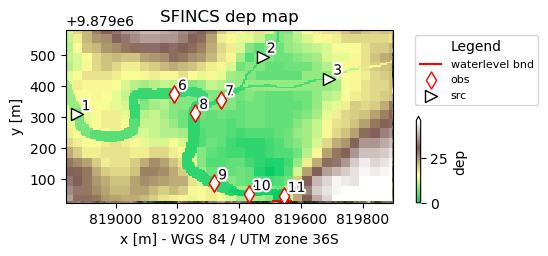

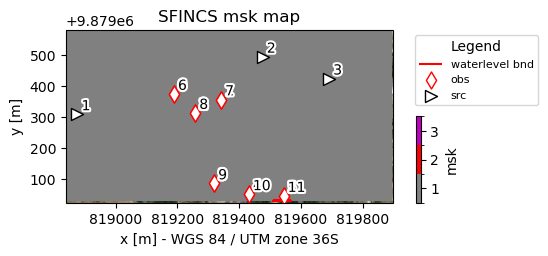

In [18]:
sf.plot_basemap(variable='dep',bmap='sat', zoomlevel=15)
sf.plot_basemap(variable='msk',bmap='sat', zoomlevel=15)

And here are your first results. 

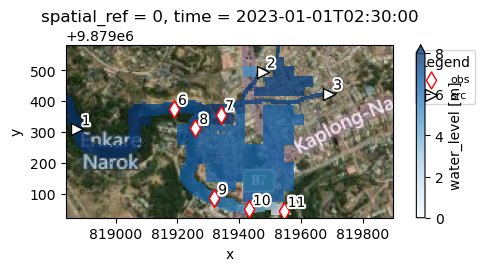

In [19]:

_ = sf.plot_basemap(variable='',bmap='sat', zoomlevel=15, plot_bounds=False)

# id is the number of timesteps times 5 minutes. 30 is 2.5 hours in the simulation
id = 30 # first output timestep
sf.results["zs"][id,:,:].plot(vmin = 0, vmax = 8, cmap = 'Blues', alpha=0.75)
# zs is waterlevel, id is the time, vmin and vmax is the range of the waterlevel.

Below here are the results for the observatory points

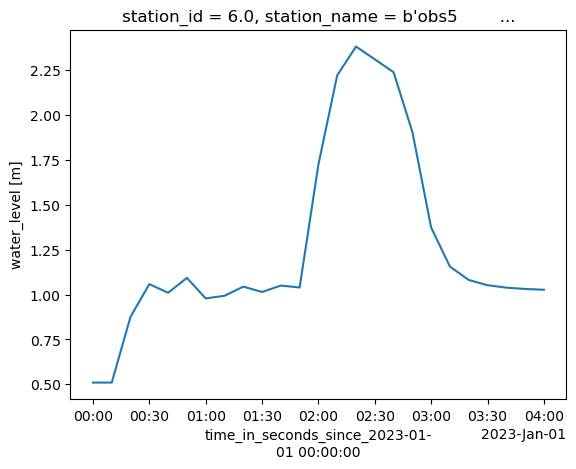

In [20]:
# id here is the number of the obs point. 
id = 5
sf.results['point_zs'][:,id].plot.line(x='time', label="0")

Below here is the animation of the whole simulation. 
DO NOT CHANGE A THING
It should work fine like this.

In [21]:
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np

# Create quick video
da_zs = sf.results["zs"].copy()

step = 1  # one frame every <step> dtout
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}

def update_plot(i, da_zs, cax_h):
    da_zs = da_zs.isel(time=i)
    t = da_zs.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f"SFINCS water depth {t}")
    cax_h.set_array(da_zs.values.ravel())

fig, ax = sf.plot_basemap(
    fn_out=None, variable="", bmap="sat", plot_bounds=False, figsize=(7, 7)
)
cax_h = da_zs.isel(time=0).plot(x="x", y="y", ax=ax, vmin=0, vmax=8, 
    cmap=plt.cm.Blues, alpha=0.75, cbar_kwargs=cbar_kwargs)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_zs.time.size, step),
    interval=250,  # ms between frames
    fargs=(da_zs, cax_h,),
)

# to show in notebook:
from IPython.display import HTML

HTML(ani.to_html5_video())